In [31]:
import warnings

import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display

warnings.simplefilter(action="ignore", category=FutureWarning)


RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

df = pd.read_csv(PATH, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]

# Split DBTL cycles
df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

print(f'Shape of df_A: {df_A.shape} and df_B: {df_B.shape}')

# Calculate bounds of proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float=0.10):
    bounds = pd.DataFrame(columns=input_vars)
    X = df[input_vars]
    for col in input_vars:
        MAX = X[col].max()
        MIN = X[col].min()
        DELTA = MAX - MIN
        lb = MIN - epsilon * DELTA
        ub = MAX + epsilon * DELTA
        if lb < 0:
            lb = 0
        bounds.loc["min", col] = lb
        bounds.loc["max", col] = ub
    return bounds

bounds = get_bounds(df_A, INPUT_VARS)
display(bounds)

Shape of df_A: (27, 10) and df_B: (3, 10)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0,0.06984,0.4676,0.06803,0.24429,0.23615,0,0,0
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


In [32]:
# import all above models
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

regressors = {
    'LR': LinearRegression(),
    'RF': RandomForestRegressor(),
    'SVR': SVR(),
    'MLP': MLPRegressor(),
    'XGB': XGBRegressor(),
    'kNN': KNeighborsRegressor(),
    'GB': GradientBoostingRegressor(),
}

# Define hyperparameter grid for each model
param_grid = {
    'LR': {'fit_intercept': [True, False]},
    'RF': {'n_estimators': [3, 5, 10, 20, 50], 'max_depth': [None, 2, 3, 5, 10, 20]},
    'SVR': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
    'MLP': {'hidden_layer_sizes': [(25,), (10,)], 'activation': ['identity', 'logistic', 'tanh', 'relu']},
    'XGB': {'n_estimators': [5, 10, 20, 50], 'max_depth': [None, 2, 3, 5, 10, 20]},
    'kNN': {'n_neighbors': [1, 2, 3, 5, 10, 20, 50], 'weights': ['uniform', 'distance']},
    'GB': {'n_estimators': [10, 20, 50], 'max_depth': [None, 2, 3, 5, 10]},
}

def model_selection():
    '''
        Define a function to perform the nested Cross Validation
    '''
    def nestedCV(model, p_grid, X, y):
        NUM_TRIALS = 3

        # Arrays to store scores
        nested_scores = []

        # Loop for each trial
        for i in tqdm(range(NUM_TRIALS)):
            
            inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
            outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

            # Nested CV with parameter optimization
            clf = GridSearchCV(estimator=model, scoring='neg_mean_absolute_error', param_grid=p_grid, 
                                    cv=inner_cv)
            
            nested_score = cross_val_score(clf, X=X, y=y, 
                                        scoring='neg_mean_absolute_error', cv=outer_cv)
            
            nested_scores.append(list(nested_score))
        return clf, nested_scores

    nested_LR, nested_LR_scores = nestedCV(regressors['LR'], param_grid['LR'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])
    nested_RF, nested_RF_scores = nestedCV(regressors['RF'], param_grid['RF'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])
    nested_SVR, nested_SVR_scores = nestedCV(regressors['SVR'], param_grid['SVR'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])
    nested_MLP, nested_MLP_scores = nestedCV(regressors['MLP'], param_grid['MLP'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])
    nested_XGB, nested_XGB_scores = nestedCV(regressors['XGB'], param_grid['XGB'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])
    nested_kNN, nested_kNN_scores = nestedCV(regressors['kNN'], param_grid['kNN'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])
    nested_GB, nested_GB_scores = nestedCV(regressors['GB'], param_grid['GB'], df_A[INPUT_VARS], df_A[RESPONSE_VARS])

    nested_scores_LR = [-item for sublist in nested_LR_scores for item in sublist]
    nested_scores_RF = [-item for sublist in nested_RF_scores for item in sublist]
    nested_scores_SVR = [-item for sublist in nested_SVR_scores for item in sublist]
    nested_scores_MLP = [-item for sublist in nested_MLP_scores for item in sublist]
    nested_scores_XGB = [-item for sublist in nested_XGB_scores for item in sublist]
    nested_scores_kNN = [-item for sublist in nested_kNN_scores for item in sublist]
    nested_scores_GB = [-item for sublist in nested_GB_scores for item in sublist]
        
    # Create a box plot for the nested scores
    def boxplot(save=True):
        plt.figure(figsize=(12, 8))
        positions = [i for i in range(1, len(regressors))]
        plt.boxplot([nested_scores_LR, nested_scores_RF, nested_scores_SVR, nested_scores_MLP, nested_scores_XGB, nested_scores_kNN, nested_scores_GB], labels=['LR', 'RF', 'SVR', 'MLP', 'XGB', 'kNN', 'GB'])
        plt.ylabel('MAE')
        # save figure
        plt.savefig('../figures/boxplot_nestedCV.png')
        plt.show()

        print(f'Mean MAE for LR: {sum(nested_scores_LR)/len(nested_scores_LR)}')
        print(f'Mean MAE for RF: {sum(nested_scores_RF)/len(nested_scores_RF)}')
        print(f'Mean MAE for SVR: {sum(nested_scores_SVR)/len(nested_scores_SVR)}')
        print(f'Mean MAE for MLP: {sum(nested_scores_MLP)/len(nested_scores_MLP)}')
        print(f'Mean MAE for XGB: {sum(nested_scores_XGB)/len(nested_scores_XGB)}')
        print(f'Mean MAE for kNN: {sum(nested_scores_kNN)/len(nested_scores_kNN)}')
        print(f'Mean MAE for GB: {sum(nested_scores_GB)/len(nested_scores_GB)}')

    boxplot()
    
    return nested_scores_LR, nested_scores_RF, nested_scores_SVR, nested_scores_MLP, nested_scores_XGB, nested_scores_kNN, nested_scores_GB


In [33]:
def train(X, y, model: str):
    grid_search = GridSearchCV(estimator=regressors[model], param_grid=param_grid[model], scoring='neg_mean_absolute_error', cv=5, verbose=1)
    grid_search.fit(X, y)
    return grid_search

def bootstrap(X, y, model: object, n: int=100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=i)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values

grid_search = train(df_A[INPUT_VARS], df_A[RESPONSE_VARS].values.ravel(), model='RF')
mae_values = bootstrap(df_A[INPUT_VARS], df_A[RESPONSE_VARS].values.ravel(), grid_search.best_estimator_)
print(f'Mean MAE: {np.mean(mae_values)}')

# Predict on DBTL_B
y_pred = grid_search.best_estimator_.predict(df_B[INPUT_VARS])
mae = mean_absolute_error(df_B[RESPONSE_VARS], y_pred)
print(f'MAE for SVR: {mae}')
results_df = pd.DataFrame({'Actual': df_B[RESPONSE_VARS].values.ravel(), 'Predicted': y_pred.ravel()})
results_df

Fitting 5 folds for each of 30 candidates, totalling 150 fits


100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 423.61it/s]

Mean MAE: 7.565831494444446
MAE for SVR: 40.07213699999999


,Actual,Predicted
0,119.81367,75.805644
1,127.99494,77.322652
2,6.72018,32.256276


#### Explainable AI 

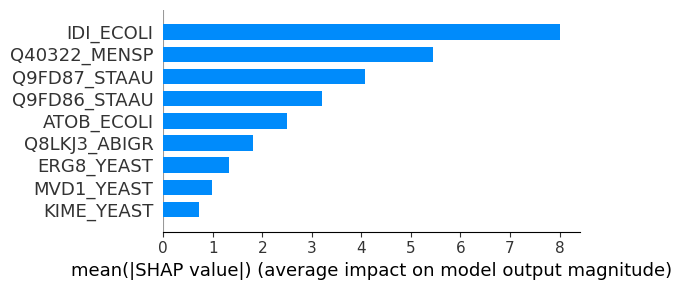

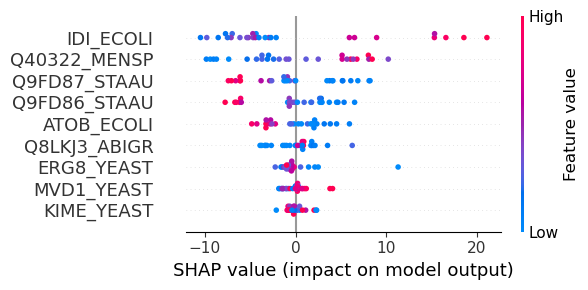

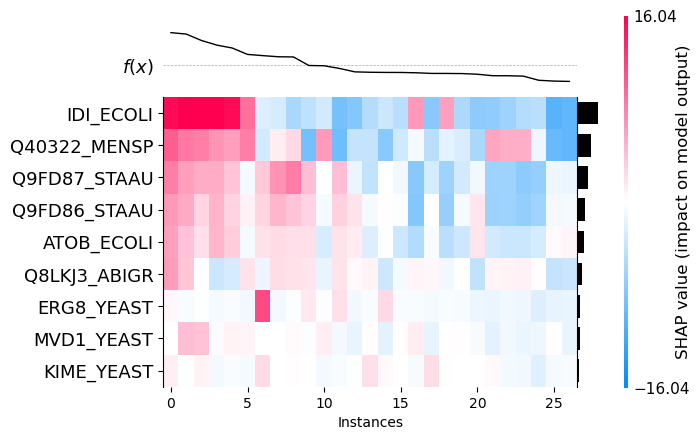

In [34]:
import shap

def pdplot(X: np.array, col: str, model: object, ice: bool=False):
    shap.plots.partial_dependence(col, model.predict, X, ice=ice, model_expected_value=True, feature_expected_value=True, show=True)
    
def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])

    
explainer = shap.Explainer(grid_search.best_estimator_.predict, df_A[INPUT_VARS])
shap_values = explainer(df_A[INPUT_VARS])
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

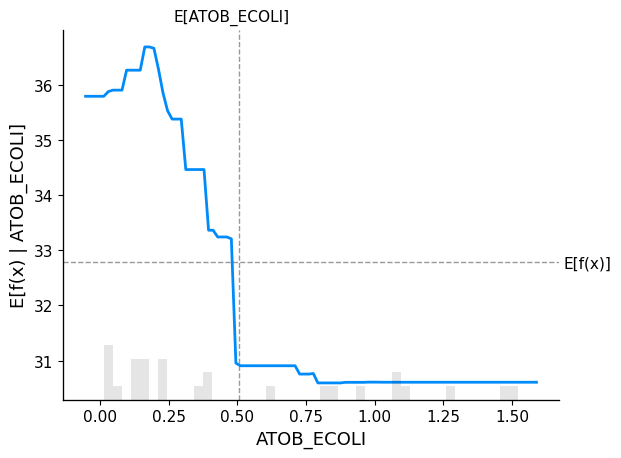

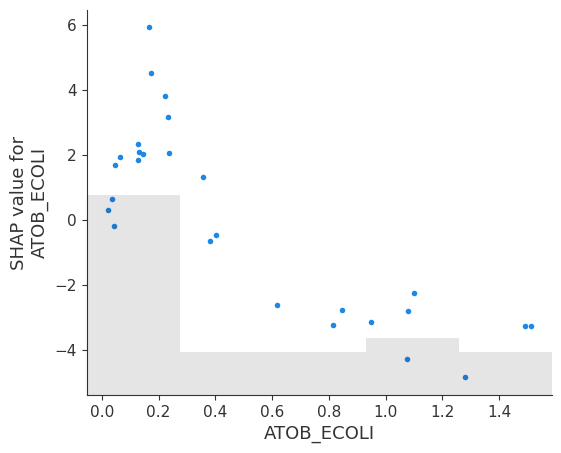

In [35]:
feature = 'ATOB_ECOLI'
pdplot(df_A[INPUT_VARS], feature, grid_search.best_estimator_, ice=False)
shap_scatter(feature)

#### Sampling

In [46]:
bounds

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0,0.06984,0.4676,0.06803,0.24429,0.23615,0,0,0
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


Create new `sampling bounds`, to generate/recommend new strain designs.

In [113]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds['Q40322_MENSP'].loc['min'] = 11
sampling_bounds['Q40322_MENSP'].loc['max'] = bounds['Q40322_MENSP'].loc['max']

sampling_bounds['ATOB_ECOLI'].loc['min'] = 1
sampling_bounds['ATOB_ECOLI'].loc['max'] = bounds['ATOB_ECOLI'].loc['max']

sampling_bounds['Q9FD87_STAAU'].loc['min'] = bounds['Q9FD87_STAAU'].loc['min']
sampling_bounds['Q9FD87_STAAU'].loc['max'] = 1.0

sampling_bounds['Q8LKJ3_ABIGR'].loc['min'] = bounds['Q8LKJ3_ABIGR'].loc['min']
sampling_bounds['Q8LKJ3_ABIGR'].loc['max'] = 1.0

sampling_bounds['Q9FD86_STAAU'].loc['min'] = bounds['Q9FD86_STAAU'].loc['min']
sampling_bounds['Q9FD86_STAAU'].loc['max'] = 0.7

sampling_bounds['MVD1_YEAST'].loc['min'] = 0.5
sampling_bounds['MVD1_YEAST'].loc['max'] = bounds['MVD1_YEAST'].loc['max']

sampling_bounds['ERG8_YEAST'].loc['min'] = bounds['ERG8_YEAST'].loc['min']
sampling_bounds['ERG8_YEAST'].loc['max'] = 0.6

sampling_bounds['KIME_YEAST'].loc['min'] = 0.2
sampling_bounds['KIME_YEAST'].loc['max'] = bounds['KIME_YEAST'].loc['max']

sampling_bounds['IDI_ECOLI'].loc['min'] = 2.5
sampling_bounds['IDI_ECOLI'].loc['max'] = bounds['IDI_ECOLI'].loc['max']

# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(10000)
LB = sampling_bounds.T['min'].values.tolist()
UB = sampling_bounds.T['max'].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = grid_search.best_estimator_.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(10)

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,pred
1125,1.362796,0.245554,3.205749,0.406123,1.961800,11.203695,0.739465,0.477762,0.819551,81.748309
7560,1.015698,0.453037,2.652386,0.377726,2.007307,11.299477,0.735675,0.468982,0.785521,81.748309
7861,1.560752,0.278917,2.725951,0.409765,1.959689,11.326791,0.817780,0.265499,0.559362,81.361525
6809,1.516378,0.368057,3.121461,0.394683,2.024966,11.670880,0.896290,0.274485,0.444884,81.361525
3230,1.618650,0.237742,3.268191,0.379157,1.995570,11.681371,0.787863,0.344593,0.463554,81.361525
6259,1.589911,0.352119,2.711646,0.400810,2.007878,12.030202,0.750535,0.494232,0.442234,81.028410
9673,1.181379,0.461808,3.414228,0.408370,2.045385,11.115475,0.994400,0.511350,0.339295,81.028410
3368,1.182423,0.434191,2.708693,0.393936,1.991734,12.187838,0.849757,0.465011,0.393779,81.028410
1411,1.270070,0.315293,2.503670,0.413370,1.958158,11.305858,0.997807,0.563480,0.408591,81.028410
4179,1.103511,0.391251,3.389400,0.384654,1.973332,11.667192,0.907431,0.463087,0.478004,81.028410


# PCA

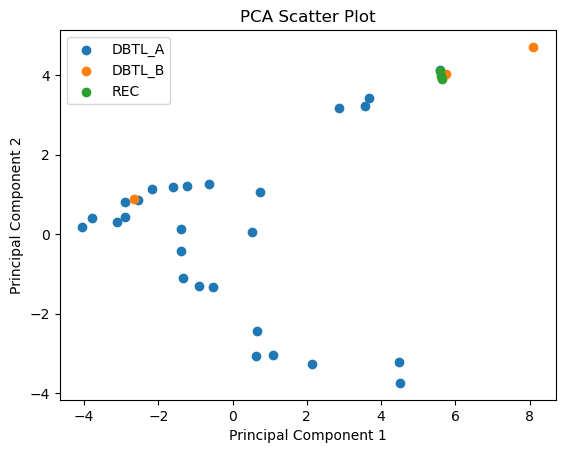

In [114]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_A[INPUT_VARS])
trans_df_A = pca.transform(df_A[INPUT_VARS])
trans_df_B = pca.transform(df_B[INPUT_VARS])
trans_rec  = pca.transform(sample_df[INPUT_VARS][:3])

# Plot
plt.scatter(trans_df_A[:,0], trans_df_A[:,1], label='DBTL_A')
plt.scatter(trans_df_B[:,0], trans_df_B[:,1], label='DBTL_B')
plt.scatter(trans_rec[:,0], trans_rec[:,1], label='REC')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.legend()
plt.show()

In [ ]:
# import all 4 sdv models under the single table scenario
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_A.drop('Limonene', axis=1))

model_Gaussian = GaussianCopulaSynthesizer(metadata)
model_Gaussian.fit(df_A.drop('Limonene', axis=1))
synthetic_data = model_Gaussian.sample(1000)
synthetic_data['Limonene'] = grid_search.best_estimator_.predict(synthetic_data)
synthetic_data.sort_values(by='Limonene', ascending=False, inplace=True)
synthetic_data